## Display function

In [1]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by=['fpr', 'tpr']).reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [2]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Function for filtering the result_list

In [3]:
import numpy as np
from sklearn.metrics import roc_curve
def filter_roc_results(results_list, results_original_roc, depth=1):
    """
    Filters the ROC results to include only those that are better than the original ROC curve.
    Each results_list item will compare its TPR against the original ROC curve's TPR at the same FPR.
    This function assumes that the results_list contains dictionaries with 'fpr', 'tpr' keys.
    If the TPR of a model at a given FPR is greater than the original model's TPR,
    it is considered a better model and included in the filtered results.
    If the FPR of a model is not present in the original ROC curve, then extrapolate
    the TPR value from the original ROC curve using linear interpolation.
    If the TPR of a model for a given FPR is equal to or worse than the original model's TPR, then
    we compute ROC results of the previous model in the list and compare the TPR with the original_model TPR for that FPR.
    If the above step still does not yield a better model, then we perform the same operation for the next model in the list.
    If still we do not find a better model, then we pick the original model as the best model for that FPR.
    The depth parameter defines how many models to look back and forward in the list
    to find a substitute model that performs better than the original model at the same FPR. 

    Args:
        results_list: A list of dictionaries containing the ROC results of the models.
        results_original_roc: A dictionary containing the ROC results of the original model.

    Returns:
        A filtered list of dictionaries containing only the relevant ROC results.
    """
    final_roc_points = []
    original_fprs = np.array(results_original_roc['fpr'])
    original_tprs = np.array(results_original_roc['tpr'])
    original_thresholds = np.array(results_original_roc['thresholds'])

    for i, current_data in enumerate(results_list):
        current_fpr = current_data["fpr"]
        current_tpr = current_data["tpr"]
        current_threshold = current_data["threshold"]

        original_tpr_at_current_fpr = np.interp(current_fpr, original_fprs, original_tprs)

        # 1. Is the current model's point better than the baseline?
        if current_tpr > original_tpr_at_current_fpr:
            final_roc_points.append({
                "model": current_data["model"],
                "fpr": current_fpr,
                "tpr": current_tpr,
                "threshold": current_threshold
            })
            continue

        # 2. NO. Search for the best substitute within the defined depth.
        best_substitute = None
        # Start by assuming the baseline is the best we can do. We need to beat this.
        best_substitute_tpr = original_tpr_at_current_fpr

        # Define the search window
        start_index = max(0, i - depth)
        end_index = min(len(results_list), i + depth + 1)

        for j in range(start_index, end_index):
            # Don't compare the model with itself
            if i == j:
                continue

            candidate_data = results_list[j]
            candidate_roc = candidate_data["full_roc"]
            
            # Find the candidate's performance at the current FPR
            candidate_tpr = np.interp(current_fpr, candidate_roc["fpr"], candidate_roc["tpr"])

            # If this candidate is the best substitute found so far...
            if candidate_tpr > best_substitute_tpr:
                best_substitute_tpr = candidate_tpr
                
                # ...find its corresponding threshold and store its info.
                idx = np.searchsorted(candidate_roc["fpr"], current_fpr)
                chosen_threshold = candidate_roc["thresholds"][max(0, idx - 1)]
                best_substitute = {
                    "model": candidate_data["model"],
                    "tpr": candidate_tpr,
                    "threshold": chosen_threshold
                }
        
        # 3. After searching, did we find a worthy substitute?
        if best_substitute:
            # YES. A substitute from the window was better than the baseline.
            best_substitute["fpr"] = current_fpr # Add the FPR to the dict
            final_roc_points.append(best_substitute)
        else:
            # NO. No model in the window was better. Fall back to the baseline.
            idx = np.searchsorted(original_fprs, current_fpr)
            chosen_threshold = original_thresholds[max(0, idx - 1)]
            final_roc_points.append({
                "model": "original_baseline",
                "fpr": current_fpr,
                "tpr": original_tpr_at_current_fpr,
                "threshold": chosen_threshold
            })

    # Find the min and max FPR values in the final results
    # if min FPR is greater than 0, use the operation points from 0 to min FPR of the model with the min FPR to fill the gap
    # we do the same for the max FPR less than 1
     # If no points were selected, return an empty list
    if not final_roc_points:
        return []

    # --- Start of the completed section ---

    # Find the point with the minimum FPR to start the curve
    min_fpr_point = min(final_roc_points, key=lambda x: x['fpr'])
    min_fpr_val = min_fpr_point['fpr']
    min_fpr_model_name = min_fpr_point['model']

    initial_points = []
    if min_fpr_val > 0:
        # Get the full ROC of the model with the minimum FPR
        if min_fpr_model_name == 'original_baseline':
            min_model_roc = results_original_roc
        else:
            min_model_data = next((item for item in results_list if item['model'] == min_fpr_model_name), None)
            min_model_roc = min_model_data['full_roc'] if min_model_data else None

        if min_model_roc:
            roc_fprs = np.array(min_model_roc['fpr'])
            roc_tprs = np.array(min_model_roc['tpr'])
            roc_thresholds = np.array(min_model_roc['thresholds'])
            
            indices_to_add = np.where(roc_fprs < min_fpr_val)[0]
            for idx in indices_to_add:
                initial_points.append({
                    "model": min_fpr_model_name,
                    "fpr": roc_fprs[idx],
                    "tpr": roc_tprs[idx],
                    "threshold": roc_thresholds[idx]
                })

    # Find the point with the maximum FPR to end the curve
    max_fpr_point = max(final_roc_points, key=lambda x: x['fpr'])
    max_fpr_val = max_fpr_point['fpr']
    max_fpr_model_name = max_fpr_point['model']
    
    trailing_points = []
    if max_fpr_val < 1.0:
        # Get the full ROC of the model with the maximum FPR
        if max_fpr_model_name == 'original_baseline':
            max_model_roc = results_original_roc
        else:
            max_model_data = next((item for item in results_list if item['model'] == max_fpr_model_name), None)
            max_model_roc = max_model_data['full_roc'] if max_model_data else None
        
        if max_model_roc:
            roc_fprs = np.array(max_model_roc['fpr'])
            roc_tprs = np.array(max_model_roc['tpr'])
            roc_thresholds = np.array(max_model_roc['thresholds'])

            indices_to_add = np.where(roc_fprs > max_fpr_val)[0]
            for idx in indices_to_add:
                trailing_points.append({
                    "model": max_fpr_model_name,
                    "fpr": roc_fprs[idx],
                    "tpr": roc_tprs[idx],
                    "threshold": roc_thresholds[idx]
                })

    # Combine all points
    combined_points = initial_points + final_roc_points + trailing_points

    # Sort by FPR (and then by descending TPR to keep the best point) and remove duplicates
    combined_points.sort(key=lambda p: (p['fpr'], -p['tpr']))
    
    unique_roc_points = []
    seen_fprs = set()
    for point in combined_points:
        if point['fpr'] not in seen_fprs:
            unique_roc_points.append(point)
            seen_fprs.add(point['fpr'])

    return unique_roc_points

## Data generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1000
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 250
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
        val_data = test_data
        
        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1000
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 250
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
        val_data = test_data
        
        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Calculate Statistics function

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        #y_prob = clf_model.predict_proba(X_test)[:, 1]
        #y_pred = (y_prob >= threshold).astype(int)
        y_pred = clf_model.predict(X_test)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





## Data1: Logistic regression

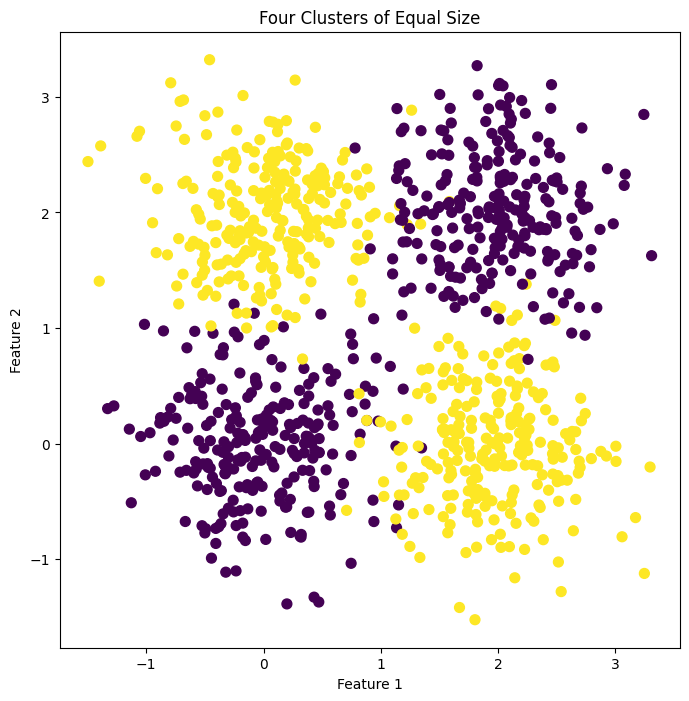

Training data shape: (800, 2), (800,)
Test data shape: (200, 2), (200,)
Estimated beta:  [ 0.80677751 -0.59085535]
Estimated intercept:  -0.574849700733691


In [6]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc

train_data, test_data, val_data = generate_data("data1")

X_train = train_data[:, :-1]  # All columns except the last one
y_train = train_data[:, -1]   # Last column is the target variable

X_test = test_data[:, :-1]  # All columns except the last one
y_test = test_data[:, -1]   # Last column is the target variable

# Logistic Regression
clf = SVC(kernel='linear', probability=True, random_state=42)
clf.fit(X_train, y_train)
beta_hat = clf.coef_[0]
beta_hat = beta_hat / np.linalg.norm(beta_hat)

# print('True beta: ', beta_star)
print('Estimated beta: ', beta_hat)
print('Estimated intercept: ', clf.intercept_[0])
# print('Mean squared error: ', np.mean((beta_star - beta_hat) ** 2))

#calculate ROC results
fpr_roc, tpr_roc, threshold_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
results_original_roc = {"fpr": fpr_roc, "tpr": tpr_roc, "thresholds": threshold_roc, "name": "SVM", "auc": auc(fpr_roc, tpr_roc), "model": clf}



### Oversampling

In [7]:
import numpy as np
from collections import Counter
# from imblearn.over_sampling import SMOTE # SMOTE is no longer used
# from sklearn.cluster import KMeans # K-Means is no longer used

# --- Configuration ---
EPSILON = 1e-9
# EXPECTED_MODES_PER_CLASS, etc. removed
# FIXED_TARGET_STD_SYNTHETIC removed

# --- Parameter for KDE-like generator ---
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed



# --- Initial Data Analysis ---
counter = Counter(y_train)
Class0_initial = counter.get(0, 0)
Class1_initial = counter.get(1, 0)


class_ratio_low = 0.1   
class_ratio_high = 100.0 
num_points_below = 100 
num_points_above = 100 

if Class1_initial == 0 and Class0_initial == 0:
    print("ERROR: Both classes have zero samples initially. Cannot proceed.")
    alpha_target_actual_values = [] 
    current_class_ratio = 1.0
elif Class1_initial == 0:
    current_class_ratio = np.inf 
else:
    current_class_ratio = Class0_initial / Class1_initial

# ... (alpha_target_actual_values generation - same robust version) ...
alpha_target_list = []
if Class0_initial > 0 or Class1_initial > 0: 
    if current_class_ratio > 0 and not np.isinf(current_class_ratio): 
        alpha_target_list.append(current_class_ratio)
    _safe_class_ratio_low = max(class_ratio_low, EPSILON)
    if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio): 
        try:
            alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
            alpha_target_list.extend(alpha_b)
        except ValueError: pass
    if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio): 
        try:
            _start_geom_above = max(current_class_ratio, _safe_class_ratio_low) 
            if class_ratio_high > _start_geom_above:
                 alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                 if not np.isclose(_start_geom_above, current_class_ratio) and current_class_ratio >=_safe_class_ratio_low and current_class_ratio <= class_ratio_high :
                     alpha_target_list.append(current_class_ratio)
                 alpha_target_list.extend(alpha_a)
            elif np.isclose(class_ratio_high, _start_geom_above):
                 alpha_target_list.append(class_ratio_high)
        except ValueError: pass
    if not alpha_target_list and (Class0_initial > 0 or Class1_initial > 0): 
        if not np.isinf(current_class_ratio) and current_class_ratio > 0:
            alpha_target_list.append(current_class_ratio)
        else: 
            alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
    alpha_target_actual_values = np.unique(alpha_target_list)
    alpha_target_actual_values = np.sort(alpha_target_actual_values[alpha_target_actual_values >= 0]) 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low] 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
    if not alpha_target_actual_values.size and (Class0_initial > 0 or Class1_initial > 0) : 
        if not np.isinf(current_class_ratio) and current_class_ratio > _safe_class_ratio_low and current_class_ratio < class_ratio_high:
            alpha_target_actual_values = np.array([current_class_ratio])
        else: 
            alpha_target_actual_values = np.array([(_safe_class_ratio_low + class_ratio_high)/2.0])


print(f"INFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio if Class1_initial > 0 else 'N/A'}")
print(f"INFO: Target ratios (w values): {alpha_target_actual_values}")
print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
print(f"INFO: Standard deviation of synthetic samples will NOT be modified after generation.")

INFO: Initial C0=407, C1=393, Ratio(0/1): 1.0356234096692112
INFO: Target ratios (w values): [  0.1          0.10236512   0.10478619   0.10726451   0.10980145
   0.11239839   0.11505675   0.11777799   0.12056358   0.12341506
   0.12633398   0.12932194   0.13238056   0.13551153   0.13871654
   0.14199736   0.14535578   0.14879362   0.15231278   0.15591516
   0.15960275   0.16337755   0.16724164   0.17119711   0.17524613
   0.17939092   0.18363374   0.18797691   0.1924228    0.19697383
   0.20163251   0.20640137   0.21128302   0.21628013   0.22139542
   0.2266317    0.23199182   0.23747871   0.24309538   0.24884489
   0.25473038   0.26075507   0.26692225   0.2732353    0.27969765
   0.28631285   0.2930845    0.30001632   0.30711207   0.31437566
   0.32181103   0.32942226   0.33721351   0.34518903   0.35335318
   0.36171042   0.37026532   0.37902256   0.38798691   0.39716329
   0.40655669   0.41617226   0.42601526   0.43609105   0.44640514
   0.45696318   0.46777093   0.47883429   0.49015

In [8]:
def oversample_dataset_KDE(Class0_initial, Class1_initial, alpha_target):
    # --- Determine Oversampling Strategy ---
    oversampled_class_label_by_strategy = -1
    initial_count_of_oversampled_class = -1
    final_count_of_oversampled_class = -1
    num_synthetic_to_generate = 0

    if Class1_initial == 0:
        if Class0_initial > 0 and alpha_target > EPSILON: 
            _Class1_final = int(round(Class0_initial / alpha_target))
            if _Class1_final > Class1_initial:
                oversampled_class_label_by_strategy = 1
                initial_count_of_oversampled_class = Class1_initial
                final_count_of_oversampled_class = _Class1_final
    elif alpha_target >= current_class_ratio: 
        _Class0_final = int(round(Class1_initial * alpha_target))
        if _Class0_final > Class0_initial:
            oversampled_class_label_by_strategy = 0
            initial_count_of_oversampled_class = Class0_initial
            final_count_of_oversampled_class = _Class0_final
    elif alpha_target < current_class_ratio: 
        if alpha_target > EPSILON: 
            _Class1_final = int(round(Class0_initial / alpha_target))
            if _Class1_final > Class1_initial:
                oversampled_class_label_by_strategy = 1
                initial_count_of_oversampled_class = Class1_initial
                final_count_of_oversampled_class = _Class1_final
    

    
    num_synthetic_to_generate = final_count_of_oversampled_class - initial_count_of_oversampled_class
    print(f"  INFO: Strategy: Oversample class {oversampled_class_label_by_strategy} from {initial_count_of_oversampled_class} to {final_count_of_oversampled_class} (generating {num_synthetic_to_generate} samples).")



    # --- KDE-like Synthetic Sample Generation ---
    print(f"  INFO: Using KDE-like generator. Perturbation sigma: {SIGMA_KDE_PERTURBATION}")
    X_new_synthetic = []
    y_new_synthetic = []

    indices_class = np.where(y_train == oversampled_class_label_by_strategy)[0]

    if len(X_train) == 0:
        print("  WARNING: X_train is empty, cannot generate synthetic samples with KDE-like method.")
        X_resampled = X_train.copy()
        y_resampled = y_train.copy()
    else:
        for _ in range(num_synthetic_to_generate):
            #idx_star = np.random.randint(0, len(X_train))
            idx_star = np.random.choice(indices_class)
            X_star = X_train[idx_star]
            epsilon_noise = np.random.randn(*X_star.shape) 
            X_prime = X_star + SIGMA_KDE_PERTURBATION * epsilon_noise
            X_new_synthetic.append(X_prime)
            y_new_synthetic.append(oversampled_class_label_by_strategy)

        if not X_new_synthetic:
            print("  INFO: No synthetic samples were actually generated by KDE-like method.")
            X_resampled = X_train.copy()
            y_resampled = y_train.copy()
        else:
            X_new_synthetic_arr = np.array(X_new_synthetic)
            y_new_synthetic_arr = np.array(y_new_synthetic)
            X_resampled = np.vstack((X_train, X_new_synthetic_arr))
            y_resampled = np.concatenate((y_train, y_new_synthetic_arr))
            resampled_counts = Counter(y_resampled)
            print(f"  INFO: KDE-like generation complete. New C0={resampled_counts.get(0,0)}, C1={resampled_counts.get(1,0)}")

    return X_resampled, y_resampled

In [9]:
'''
from sklearn.metrics import roc_curve, auc

list_weighted_clfs = []

for w_idx, w in enumerate(alpha_target_actual_values):
    print(f"\n--- Processing target ratio w ({w_idx+1}/{len(alpha_target_actual_values)}): {w:.4f} ---")
    X_train, y_train = oversample_dataset_KDE(Class0_initial, Class1_initial, w)

    clf_weighted = SVC(kernel='linear', probability=True, random_state=42)
    clf_weighted.fit(X_train, y_train)

    res = get_fpr_tpr(clf_weighted, X_test, y_test, threshold=0.5)

    array_of_all_fprs, array_of_all_tprs, threshold_vals = roc_curve(y_test, clf_weighted.predict_proba(X_test)[:, 1])

    current_result = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "threshold": 0.5,
        "full_roc": {"fpr": array_of_all_fprs, "tpr": array_of_all_tprs, "thresholds": threshold_vals},
    }
    list_weighted_clfs.append(current_result)
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")
'''

'\nfrom sklearn.metrics import roc_curve, auc\n\nlist_weighted_clfs = []\n\nfor w_idx, w in enumerate(alpha_target_actual_values):\n    print(f"\n--- Processing target ratio w ({w_idx+1}/{len(alpha_target_actual_values)}): {w:.4f} ---")\n    X_train, y_train = oversample_dataset_KDE(Class0_initial, Class1_initial, w)\n\n    clf_weighted = SVC(kernel=\'linear\', probability=True, random_state=42)\n    clf_weighted.fit(X_train, y_train)\n\n    res = get_fpr_tpr(clf_weighted, X_test, y_test, threshold=0.5)\n\n    array_of_all_fprs, array_of_all_tprs, threshold_vals = roc_curve(y_test, clf_weighted.predict_proba(X_test)[:, 1])\n\n    current_result = {\n        "model": clf_weighted,\n        "fpr": res["fpr"],\n        "tpr": res["tpr"],\n        "threshold": 0.5,\n        "full_roc": {"fpr": array_of_all_fprs, "tpr": array_of_all_tprs, "thresholds": threshold_vals},\n    }\n    list_weighted_clfs.append(current_result)\n    #print(f"Weight: {w:.2f}, FPR: {res[\'fpr\']:.3f}, TPR: {res[\'t

### Parallel Execution

In [10]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from joblib import Parallel, delayed

def process_single_weight(w, X_initial, y_initial, X_test, y_test):
    """
    This is the worker function. It performs all the steps for a single
    value of 'w' and returns the result dictionary.
    """
    print(f"--- Processing target ratio w: {w:.4f} ---")

    # 1. Oversample the dataset for the given weight 'w'
    X_train, y_train = oversample_dataset_KDE(
        Class0_initial=X_initial,
        Class1_initial=y_initial,
        alpha_target=w
    )

    # 2. Train the model
    clf_weighted = SVC(kernel='linear', probability=True, random_state=42)
    clf_weighted.fit(X_train, y_train)

    # 3. Evaluate the model
    # Get a single point at threshold 0.5
    res = get_fpr_tpr(clf_weighted, X_test, y_test, threshold=0.5)
    # Get the full ROC curve data
    y_scores = clf_weighted.predict_proba(X_test)[:, 1]
    array_of_all_fprs, array_of_all_tprs, threshold_vals = roc_curve(y_test, y_scores)

    # 4. Compile the results into a dictionary and return it
    current_result = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "threshold": 0.5,
        "full_roc": {"fpr": array_of_all_fprs, "tpr": array_of_all_tprs, "thresholds": threshold_vals},
    }
    return current_result

In [11]:
if __name__ == "__main__":
    # Use joblib.Parallel to execute the worker function for each 'w'
    # n_jobs=-1 tells joblib to use all available CPU cores.
    # verbose=10 will print progress updates, which is very helpful.
    list_weighted_clfs = Parallel(n_jobs=-1, verbose=10)(
        delayed(process_single_weight)(
            w,
            Class0_initial,
            Class1_initial,
            X_test,
            y_test
        ) for w in alpha_target_actual_values
    )

    # The 'list_weighted_clfs' variable now contains the list of all result dictionaries,
    # in the same order as your original alpha_target_actual_values list.
    print(f"\nParallel processing complete. Collected {len(list_weighted_clfs)} results.")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


--- Processing target ratio w: 0.1024 ---
  INFO: Strategy: Oversample class 1 from 393 to 3976 (generating 3583 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.1098 ---
  INFO: Strategy: Oversample class 1 from 393 to 3707 (generating 3314 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.1073 ---
  INFO: Strategy: Oversample class 1 from 393 to 3794 (generating 3401 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.1000 ---
  INFO: Strategy: Oversample class 1 from 393 to 4070 (generating 3677 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.1151 ------ Processing target ratio w: 0.1206 ---
  INFO: Strategy: Oversample class 1 from 393 to 3376 (generating 2983 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1

  INFO: Strategy: Oversample class 1 from 393 to 3537

[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.2s


--- Processing target ratio w: 0.1596 ---
  INFO: Strategy: Oversample class 1 from 393 to 2550 (generating 2157 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.1634 ---
  INFO: Strategy: Oversample class 1 from 393 to 2491 (generating 2098 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.1672 ---
  INFO: Strategy: Oversample class 1 from 393 to 2434 (generating 2041 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.1712 ---
  INFO: Strategy: Oversample class 1 from 393 to 2377 (generating 1984 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.1752 ---
  INFO: Strategy: Oversample class 1 from 393 to 2322 (generating 1929 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.1794 ---
  INFO: Strategy: Oversample class 1 from 393 to 2269

[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    2.7s


--- Processing target ratio w: 0.2547 ---
  INFO: Strategy: Oversample class 1 from 393 to 1598 (generating 1205 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.2608 ---
  INFO: Strategy: Oversample class 1 from 393 to 1561 (generating 1168 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.2669 ---
  INFO: Strategy: Oversample class 1 from 393 to 1525 (generating 1132 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.2732 ---
  INFO: Strategy: Oversample class 1 from 393 to 1490 (generating 1097 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.2797 ---
  INFO: Strategy: Oversample class 1 from 393 to 1455 (generating 1062 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.2863 ---
  INFO: Strategy: Oversample class 1 from 393 to 1422

[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    3.0s


--- Processing target ratio w: 0.6799 ---
  INFO: Strategy: Oversample class 1 from 393 to 599 (generating 206 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.6960 ---
  INFO: Strategy: Oversample class 1 from 393 to 585 (generating 192 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 0.7125 ---
  INFO: Strategy: Oversample class 1 from 393 to 571 (generating 178 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=407, C1=627
--- Processing target ratio w: 0.7293 ---
  INFO: Strategy: Oversample class 1 from 393 to 558 (generating 165 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=407, C1=613
  INFO: KDE-like generation complete. New C0=407, C1=599
  INFO: KDE-like generation complete. New C0=407, C1=585
--- Processing target ratio w: 0.7466 ---
  INFO: Strate

[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.3s


--- Processing target ratio w: 2.4896 ---
  INFO: Strategy: Oversample class 0 from 407 to 978 (generating 571 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 2.6072 ---
  INFO: Strategy: Oversample class 0 from 407 to 1025 (generating 618 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=978, C1=393
--- Processing target ratio w: 2.7304 ---
  INFO: Strategy: Oversample class 0 from 407 to 1073 (generating 666 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 2.8594 ---
  INFO: Strategy: Oversample class 0 from 407 to 1124 (generating 717 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 2.9944 ---
  INFO: Strategy: Oversample class 0 from 407 to 1177 (generating 770 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0

[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    3.6s



--- Processing target ratio w: 5.4569 ---
  INFO: Strategy: Oversample class 0 from 407 to 2145 (generating 1738 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 5.7147 ---
  INFO: Strategy: Oversample class 0 from 407 to 2246 (generating 1839 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1867, C1=393
  INFO: KDE-like generation complete. New C0=2048, C1=393
  INFO: KDE-like generation complete. New C0=1955, C1=393
  INFO: KDE-like generation complete. New C0=2246, C1=393
  INFO: KDE-like generation complete. New C0=2145, C1=393
--- Processing target ratio w: 5.9847 ---
  INFO: Strategy: Oversample class 0 from 407 to 2352 (generating 1945 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 6.2675 ---
  INFO: Strategy: Oversample class 0 from 407 to 2463 (generating 2056 samples).
  INFO: Using KDE-like generator. Perturbat

[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    4.0s


  INFO: KDE-like generation complete. New C0=6801, C1=393
--- Processing target ratio w: 23.9055 ---
  INFO: Strategy: Oversample class 0 from 407 to 9395 (generating 8988 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=7122, C1=393
  INFO: KDE-like generation complete. New C0=7458, C1=393
  INFO: KDE-like generation complete. New C0=7811, C1=393
--- Processing target ratio w: 25.0349 ---
  INFO: Strategy: Oversample class 0 from 407 to 9839 (generating 9432 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 26.2177 ---
  INFO: Strategy: Oversample class 0 from 407 to 10304 (generating 9897 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 27.4564 ---
  INFO: Strategy: Oversample class 0 from 407 to 10790 (generating 10383 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete.

[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    5.0s


--- Processing target ratio w: 41.5986 ---
  INFO: Strategy: Oversample class 0 from 407 to 16348 (generating 15941 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 43.5640 ---
  INFO: Strategy: Oversample class 0 from 407 to 17121 (generating 16714 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
--- Processing target ratio w: 45.6222 ---
  INFO: Strategy: Oversample class 0 from 407 to 17930 (generating 17523 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=13592, C1=393
--- Processing target ratio w: 47.7776 ---
  INFO: Strategy: Oversample class 0 from 407 to 18777 (generating 18370 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=14906, C1=393
  INFO: KDE-like generation complete. New C0=14234, C1=393
  INFO: KDE-like generation complete. New C0=15611, C1=393
--- Processing target ratio 

[Parallel(n_jobs=-1)]: Done 182 out of 200 | elapsed:    8.0s remaining:    0.8s


  INFO: KDE-like generation complete. New C0=34217, C1=393
  INFO: KDE-like generation complete. New C0=35834, C1=393
  INFO: KDE-like generation complete. New C0=37527, C1=393
  INFO: KDE-like generation complete. New C0=39300, C1=393

Parallel processing complete. Collected 200 results.


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.3s finished


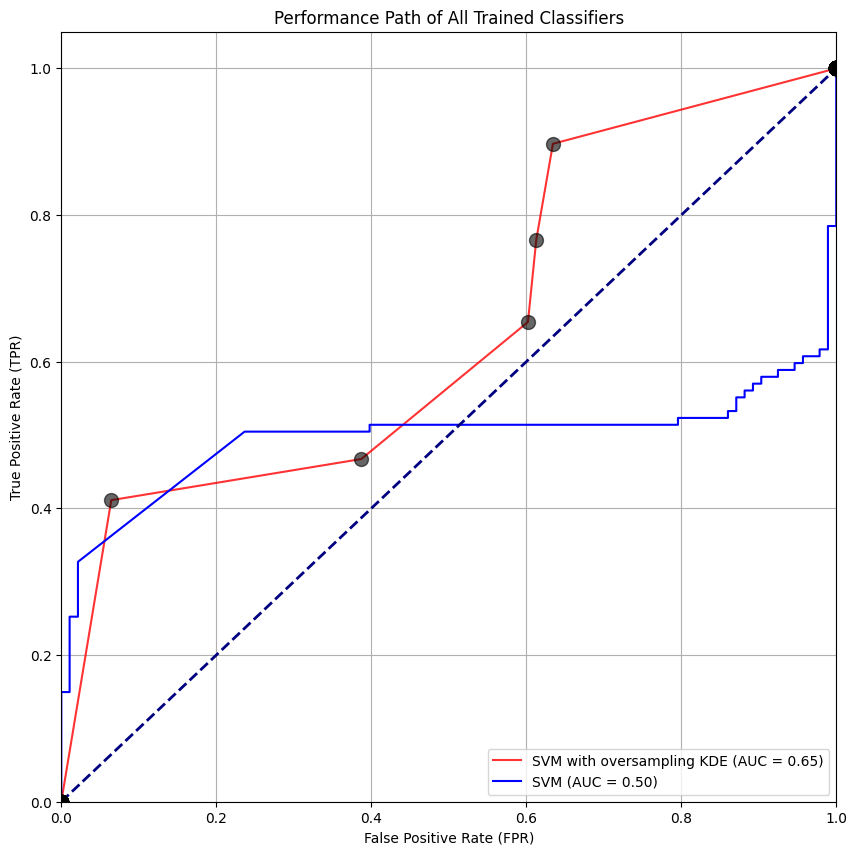

In [12]:
plot_roc_connected_points(list_weighted_clfs, results_original_roc, name="SVM with oversampling KDE")

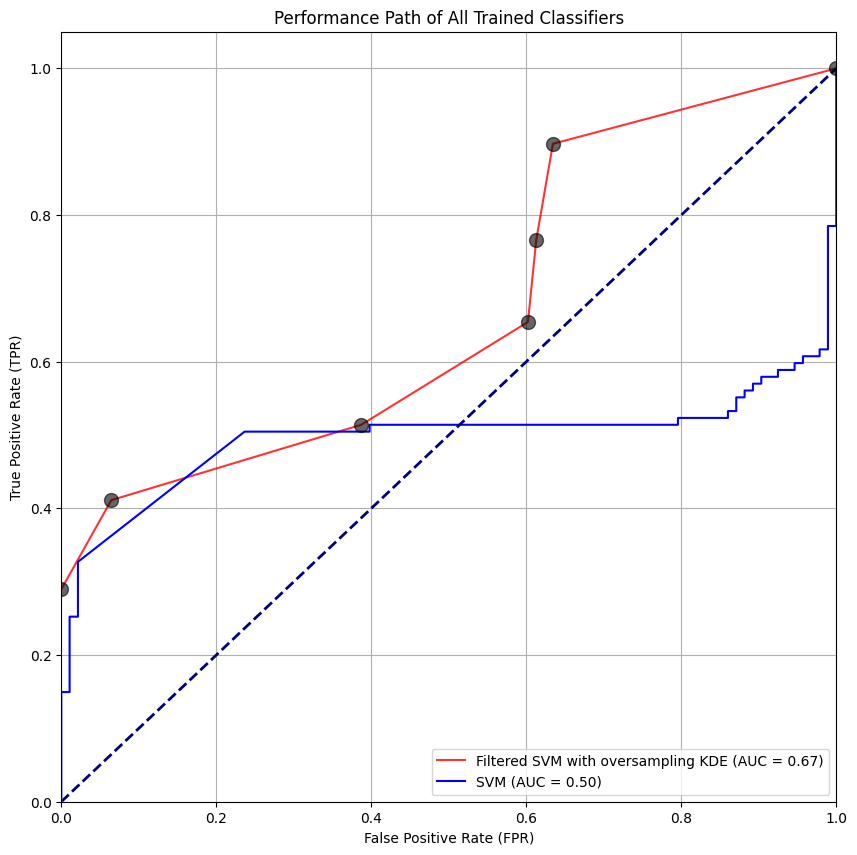

In [13]:
#filter the results
filtered_results = filter_roc_results(list_weighted_clfs, results_original_roc, depth=10)
# Plot the filtered results
plot_roc_connected_points(filtered_results, results_original_roc, name="Filtered SVM with oversampling KDE")

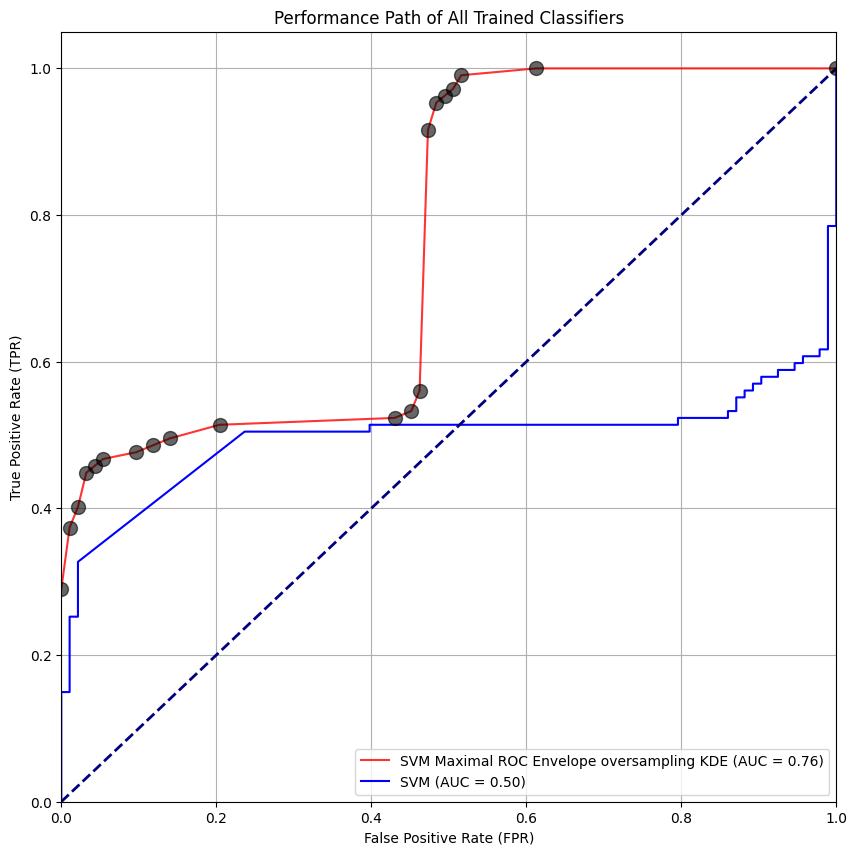

In [14]:
best_envelope = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
# Plot the best ROC envelope
plot_roc_connected_points(best_envelope, results_original_roc, name="SVM Maximal ROC Envelope oversampling KDE")